# Gaussian Process Regression (2 dim)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=np.inf) # do not wrap lines

## Generate Training and Test Data

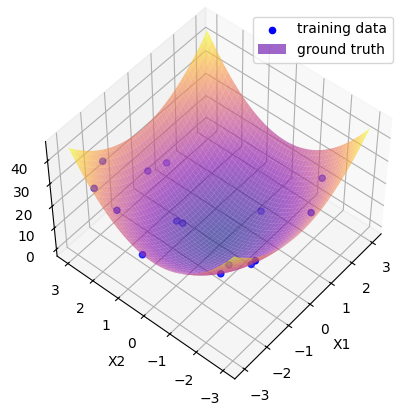

In [9]:
# generate training data and test data for regression

# ground truth function
def ground_truth_func(x: np.ndarray) -> float:
    """ x: [x1, x2] =>  y: scalar """
    x1, x2 = x
    return 2.0 * x1 * x1 + 3.0 * x2 * x2

def ground_truth_func_mesh2d(xs_array: np.ndarray) -> np.ndarray:
    """ xs_array: [x1_mesh_array(2d), x2_mesh_array(2d)] =>  y_mesh_array: [y (the same shape as x1_array and x2_array)] """
    y_mesh_array = np.zeros(xs_array.shape[1:])
    for x1idx in range(xs_array.shape[1]):
        for x2idx in range(xs_array.shape[2]):
            y_mesh_array[x1idx, x2idx] = ground_truth_func([xs_array[0, x1idx, x2idx], xs_array[1, x1idx, x2idx]])
    return y_mesh_array

## settings
min_x1, max_x1 = -3.0, +3.0
min_x2, max_x2 = -3.0, +3.0
train_data_size = 15
test_data_size_x1 = 50
test_data_size_x2 = 100
test_data_size = test_data_size_x1 * test_data_size_x2

## generate data
### training data
np.random.seed(1)
x1_train = np.random.uniform(min_x1, max_x1, train_data_size)
x2_train = np.random.uniform(min_x2, max_x2, train_data_size)
y_train = np.array([ground_truth_func([x1_train[train_idx], x2_train[train_idx]]) for train_idx in range(train_data_size)])
X_train = np.stack([x1_train, x2_train], axis=1)

### test data
x1_test = np.linspace(min_x1, max_x1, test_data_size_x1)
x2_test = np.linspace(min_x2, max_x2, test_data_size_x2)
#### save data as mesh
x1_test_mesh, x2_test_mesh = np.meshgrid(x1_test, x2_test)
X_test_mesh = np.stack([x1_test_mesh, x2_test_mesh], axis=0)
y_test_mesh = ground_truth_func_mesh2d(X_test_mesh)
#### save data as list
X_test_list = np.stack([x1_test_mesh.flatten(), x2_test_mesh.flatten()], axis=1) # => this will be used for gpr.fit()
y_test_list = y_test_mesh.flatten()

## 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# plot training data as scatter plot
ax.scatter(x1_train, x2_train, y_train, c='blue', marker='o', label='training data')
# plot surface of ground truth function
ax.plot_surface(x1_test_mesh, x2_test_mesh, y_test_mesh, cmap="plasma", alpha=0.6, label='ground truth')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.view_init(elev=50, azim=-140) # rotate the 3d view
plt.legend()
plt.show()

## Define Kernel Function

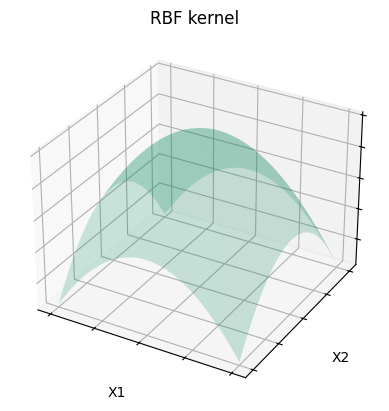

In [10]:
# TODO: use matern kernel
## ref: https://boritaso-blog.com/gaussian_process_regression_kernel/#toc4

# define kernel function
def rbf_kernel(x_i: np.ndarray, x_j: np.ndarray) -> float:
    theta_1 = 1.0
    theta_2 = 20.0
    return theta_1 * np.exp(-1.0 * np.linalg.norm(x_i - x_j, ord=2) ** 2 / theta_2)

# plot kernel function in 3D
x1 = np.linspace(-1.0, 1.0, 100)
x2 = np.linspace(-1.0, 1.0, 100)
x1_mesh, x2_mesh = np.meshgrid(x1, x2)
y_mesh = np.zeros(x1_mesh.shape)
for i in range(x1_mesh.shape[0]):
    for j in range(x1_mesh.shape[1]):
        y_mesh[i, j] = rbf_kernel(np.array([x1_mesh[i, j], x2_mesh[i, j]]), np.array([0.0, 0.0]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1_mesh, x2_mesh, y_mesh, color="#03AF7A", alpha=0.2)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('RBF kernel')
ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.show()


## Execute Gaussian Process Regression

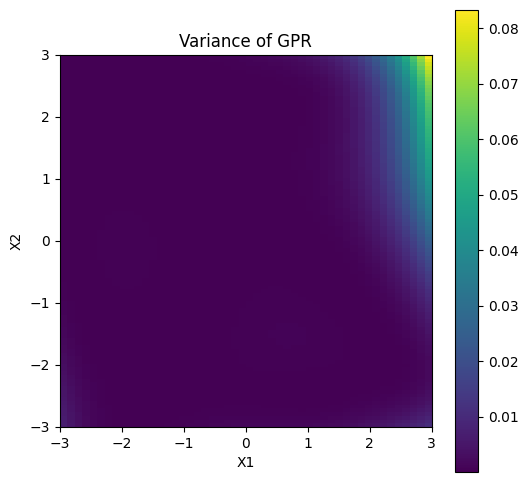

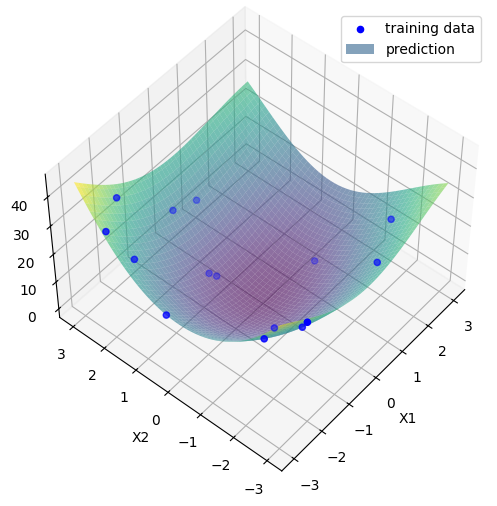

In [11]:
class GaussianProcessRegression:
    def __init__(self, kernel):
        self.kernel = kernel

    def fit(self, X_test: np.ndarray, X_train: np.ndarray, y_train: np.ndarray):
        # get matrix size
        train_data_size = X_train.shape[0]

        # calculate kernel matrix K (train_data_size x train_data_size)
        K = np.zeros((train_data_size, train_data_size))
        for r in range(train_data_size):
            for c in range(train_data_size):
                K[r, c] = self.kernel(X_train[r], X_train[c])

        # calculate expanded kernel matrix K_big (train_data_size x test_data_size)        
        K_big = np.zeros((train_data_size, test_data_size))
        for r in range(train_data_size):
            for c in range(test_data_size):
                K_big[r, c] = self.kernel(X_train[r], X_test[c])

        # calculate mean and variance
        s = self.kernel(X_test, X_test)
        yy = np.linalg.inv(K) @ y_train
        y_pred = K_big.T @ yy
        y_var = s - np.diag(K_big.T @ np.linalg.inv(K) @ K_big)

        # return prediction and variance as lists
        return y_pred, y_var

    def optimize(self):
        # TODO: optimize hyperparameters automatically
        pass

# instanciate the GPR class
gpr = GaussianProcessRegression(kernel=rbf_kernel)

# fit the model
y_pred_list, y_var_list = gpr.fit(X_test_list, X_train, y_train)

# plot the variance in 2d
y_var_mesh = y_var_list.reshape(test_data_size_x2, test_data_size_x1)
plt.figure(figsize=(6, 6))
plt.imshow(y_var_mesh, cmap='viridis', extent=[min_x1, max_x1, min_x2, max_x2], origin='lower')
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Variance of GPR')
plt.savefig('gpr_2d_variance.png', dpi=300)
plt.show()

# plot the prediction of GPR in 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.scatter(x1_train, x2_train, y_train, c='blue', marker='o', zorder=2, label='training data')

# convert y_pred_list to mesh
y_pred_mesh = y_pred_list.reshape(test_data_size_x2, test_data_size_x1) # confusing order, but correct

# plot surface of gpr prediction
ax.plot_surface(x1_test_mesh, x2_test_mesh, y_pred_mesh, cmap='viridis', alpha=0.6, zorder=1, label='prediction')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.view_init(elev=50, azim=-140) # rotate the 3d view
plt.legend()
plt.savefig('gpr_2d_prediction.png', dpi=300)
plt.show()